In [4]:
import csv
 
import operator
 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib
import seaborn as sb

matplotlib.use("Agg")  # Needed to save figures
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
print(pd.show_versions())


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.6.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
machine          : AMD64
processor        : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.None

pandas           : 1.0.1
numpy            : 1.18.1
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 20.0.2
setuptools       : 45.2.0.post20200210
Cython           : None
pytest           : 5.4.1
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.11.1
IPython          : 7.12.0
pandas_datareader: None
bs4              : 4.8.2
bottleneck       : None
fastparquet      : None
gcsfs            : None
lxml.etree       : None
matp

In [6]:
types = {'CompetitionOpenSinceYear': np.dtype(int),
        'CompetitionOpenSinceMonth': np.dtype(int),
        'StateHoliday': np.dtype(str),
        'Promo2SinceWeek': np.dtype(int),
        'SchoolHoliday': np.dtype(float),
        'PromoInterval': np.dtype(str)}
train = pd.read_csv("./data/train.csv", parse_dates=[2], dtype=types)
test = pd.read_csv("./data/test.csv", parse_dates=[3], dtype=types)
store = pd.read_csv("./data/store.csv")


In [7]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1.0
1,2,5,2015-07-31,6064,625,1,1,0,1.0
2,3,5,2015-07-31,8314,821,1,1,0,1.0
3,4,5,2015-07-31,13995,1498,1,1,0,1.0
4,5,5,2015-07-31,4822,559,1,1,0,1.0


In [72]:
print(store.shape)
print(train.shape)
print(test.shape)

(1115, 10)
(1017209, 9)
(41088, 8)


In [73]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 69.8+ MB


In [74]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [9]:
#合并数据集
train = pd.merge(train,store,on='Store')
test = pd.merge(test,store,on='Store')



## EDA

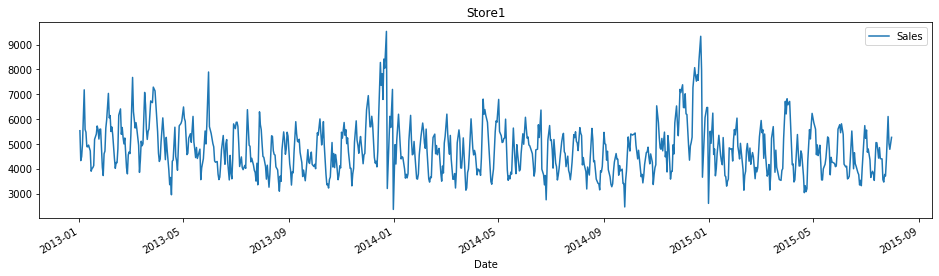

In [38]:

strain=train[train['Sales']>0]
strain.loc[strain['Store']==1,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(16,4))


## 特征工程

In [10]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

In [11]:
 
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y - 1) ** 2))
 

In [12]:
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

In [13]:
features = []

In [14]:
def build_features(features,data):
    features.extend(['Store', 'CompetitionDistance',
                 'Promo', 'Promo2', 'SchoolHoliday'])
    features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    mappings = {0: 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4}
    
    data['StoreType'] = data['StoreType'].astype(object).replace(mappings, inplace=True)
    data['Assortment'] = data['Assortment'].astype(object).replace(mappings, inplace=True)
    data['StateHoliday'] = data['StateHoliday'].astype(object).replace(mappings, inplace=True)
    data['Date']=pd.to_datetime(data['Date'])
    
    features.extend(['DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day
    data['DayOfWeek'] = data['Date'].dt.dayofweek
    data['WeekOfYear'] = data['Date'].dt.weekofyear
    
    features.append('CompetitionOpen')
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
                                (data.Month - data.CompetitionOpenSinceMonth)
    
    features.append('PromoOpen')
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
                        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0
    
    
    return data

In [15]:
features = []
build_features(features,train)
build_features([],test)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen
0,1,1,3,2015-09-17,1.0,1,None,0.0,None,None,...,0,NaN,NaN,None,2015,9,17,38,84.0,0.00
1,857,1,2,2015-09-16,1.0,1,None,0.0,None,None,...,0,NaN,NaN,None,2015,9,16,38,84.0,0.00
2,1713,1,1,2015-09-15,1.0,1,None,0.0,None,None,...,0,NaN,NaN,None,2015,9,15,38,84.0,0.00
3,2569,1,0,2015-09-14,1.0,1,None,0.0,None,None,...,0,NaN,NaN,None,2015,9,14,38,84.0,0.00
4,3425,1,6,2015-09-13,0.0,0,None,0.0,None,None,...,0,NaN,NaN,None,2015,9,13,37,84.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,37664,1115,2,2015-08-05,1.0,1,None,1.0,None,None,...,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2015,8,5,32,NaN,38.50
41084,38520,1115,1,2015-08-04,1.0,1,None,1.0,None,None,...,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2015,8,4,32,NaN,38.50
41085,39376,1115,0,2015-08-03,1.0,1,None,1.0,None,None,...,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2015,8,3,32,NaN,38.50
41086,40232,1115,6,2015-08-02,0.0,0,None,1.0,None,None,...,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2015,8,2,31,NaN,38.25


In [16]:
print(features)

['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen']


## 训练模型

In [17]:
#参数
params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
         }
num_boost_round = 300



In [18]:

train.fillna(1, inplace=True)
test.fillna(1, inplace=True)


In [19]:
train = train[train["Open"] != 0]
train = train[train["Sales"] > 0]

In [20]:
#训练模型
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
y_train = X_train.Sales
y_valid = X_valid.Sales
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)


It is clear to see the sales shows a typical exponential distribution


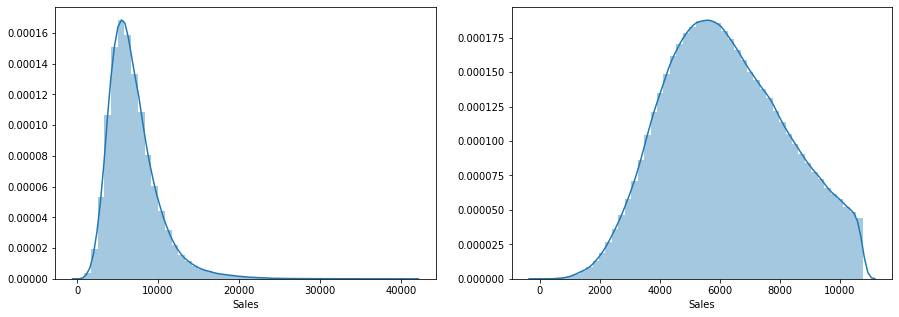

In [21]:
import seaborn as sb
print('It is clear to see the sales shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sb.distplot(y_train)
plt.subplot(1,2,2)
sb.distplot(y_train[y_train < np.quantile(y_train, 0.9)])
# .savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

这里很明显可以看出来数据的标签（Sales）是长尾分布，并不利于数据的预测，因为很多的模型都假设数据符合正态分布，所以我们需要对长尾分布的数据进行对数变换。

In [22]:
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)

The transformed sales seems like normal distribution


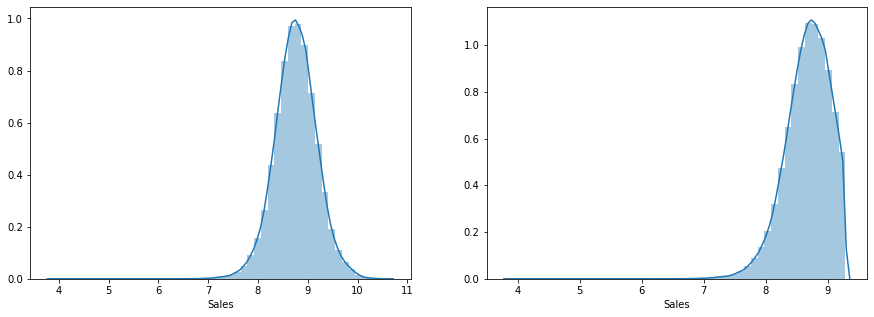

In [23]:
import seaborn as sb
print('The transformed sales seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sb.distplot(y_train)
plt.subplot(1,2,2)
sb.distplot(y_train[y_train < np.quantile(y_train, 0.9)])

In [21]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
                early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:5.79443	eval-rmse:5.79828	train-rmspe:0.99682	eval-rmspe:0.99683
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:4.06479	eval-rmse:4.06840	train-rmspe:0.98137	eval-rmspe:0.98141
[2]	train-rmse:2.85647	eval-rmse:2.85976	train-rmspe:0.93750	eval-rmspe:0.93759
[3]	train-rmse:2.01466	eval-rmse:2.01792	train-rmspe:0.85549	eval-rmspe:0.85556
[4]	train-rmse:1.43006	eval-rmse:1.43327	train-rmspe:0.74258	eval-rmspe:0.74225
[5]	train-rmse:1.02535	eval-rmse:1.02868	train-rmspe:0.61931	eval-rmspe:0.61777
[6]	train-rmse:0.74906	eval-rmse:0.75218	train-rmspe:0.50660	eval-rmspe:0.50235
[7]	train-rmse:0.56755	eval-rmse:0.57032	train-rmspe:0.42029	eval-rmspe:0.41159
[8]	train-rmse:0.44688	eval-rmse:0.45004	train-rmspe:0.35775	eval-rmspe:0.34924
[9]	train-rmse:0.37263	eval-rmse:0.37547	train-rmspe:0.32533	eval-rmspe:0.31357
[10]	train-rmse:0.32895	eval-rmse:0.33206	train-rmspe:

[100]	train-rmse:0.11148	eval-rmse:0.11694	train-rmspe:0.14022	eval-rmspe:0.12675
[101]	train-rmse:0.11120	eval-rmse:0.11673	train-rmspe:0.13997	eval-rmspe:0.12653
[102]	train-rmse:0.11063	eval-rmse:0.11618	train-rmspe:0.13946	eval-rmspe:0.12591
[103]	train-rmse:0.10978	eval-rmse:0.11539	train-rmspe:0.13867	eval-rmspe:0.12509
[104]	train-rmse:0.10902	eval-rmse:0.11486	train-rmspe:0.13800	eval-rmspe:0.12457
[105]	train-rmse:0.10864	eval-rmse:0.11459	train-rmspe:0.13767	eval-rmspe:0.12431
[106]	train-rmse:0.10837	eval-rmse:0.11445	train-rmspe:0.13742	eval-rmspe:0.12416
[107]	train-rmse:0.10798	eval-rmse:0.11410	train-rmspe:0.13706	eval-rmspe:0.12376
[108]	train-rmse:0.10763	eval-rmse:0.11378	train-rmspe:0.13672	eval-rmspe:0.12341
[109]	train-rmse:0.10738	eval-rmse:0.11358	train-rmspe:0.13651	eval-rmspe:0.12322
[110]	train-rmse:0.10703	eval-rmse:0.11330	train-rmspe:0.13600	eval-rmspe:0.12293
[111]	train-rmse:0.10688	eval-rmse:0.11316	train-rmspe:0.13588	eval-rmspe:0.12280
[112]	train-rmse

[200]	train-rmse:0.08959	eval-rmse:0.10162	train-rmspe:0.11084	eval-rmspe:0.10952
[201]	train-rmse:0.08943	eval-rmse:0.10143	train-rmspe:0.11069	eval-rmspe:0.10922
[202]	train-rmse:0.08922	eval-rmse:0.10131	train-rmspe:0.10963	eval-rmspe:0.10906
[203]	train-rmse:0.08906	eval-rmse:0.10127	train-rmspe:0.10696	eval-rmspe:0.10903
[204]	train-rmse:0.08895	eval-rmse:0.10120	train-rmspe:0.10686	eval-rmspe:0.10897
[205]	train-rmse:0.08892	eval-rmse:0.10119	train-rmspe:0.10683	eval-rmspe:0.10897
[206]	train-rmse:0.08878	eval-rmse:0.10113	train-rmspe:0.10668	eval-rmspe:0.10889
[207]	train-rmse:0.08862	eval-rmse:0.10104	train-rmspe:0.10611	eval-rmspe:0.10883
[208]	train-rmse:0.08849	eval-rmse:0.10097	train-rmspe:0.10599	eval-rmspe:0.10875
[209]	train-rmse:0.08833	eval-rmse:0.10085	train-rmspe:0.10582	eval-rmspe:0.10862
[210]	train-rmse:0.08806	eval-rmse:0.10070	train-rmspe:0.10476	eval-rmspe:0.10846
[211]	train-rmse:0.08795	eval-rmse:0.10066	train-rmspe:0.10463	eval-rmspe:0.10842
[212]	train-rmse

In [22]:
print("Validating")
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

Validating
RMSPE: 0.102849


In [23]:

print("Make predictions on the test set")
dtest = xgb.DMatrix(test[features])
test_probs = gbm.predict(dtest)


Make predictions on the test set


In [24]:
# Make Submission
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs)})
result.to_csv("xgboost_10_submission.csv", index=False)


In [25]:
# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code
 
create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

In [26]:

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()


In [28]:
df['fscore'] 

0     0.010517
1     0.025164
2     0.037059
3     0.037185
4     0.075667
5     0.092061
6     0.097804
7     0.103087
8     0.112190
9     0.120229
10    0.134849
11    0.154189
Name: fscore, dtype: float64

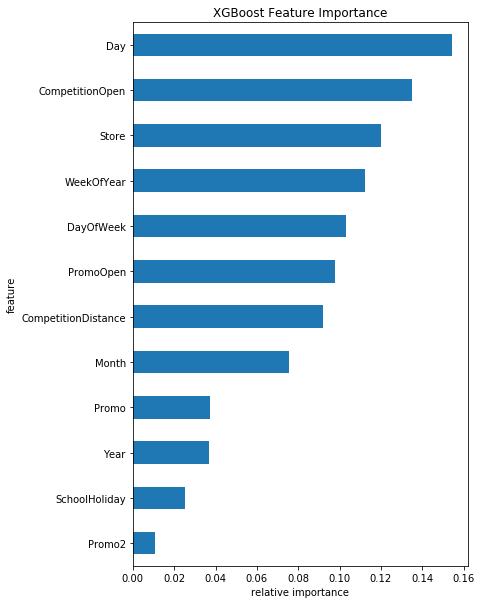

In [27]:
featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)